# Active learning of potential energy surfaces 
Active learning (AL) algorithms allows one to build machine learning algorithms with a reduced amount of data. In this tutorial we will learn some AL algorithms and how to use them to build potential-energy surfaces of molecules. 

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install Cython
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install h5py
!pip install git+https://github.com/ntucllab/libact.git


## Reading data 
We will consider the example of building the PES of a pyrrole water dimer. For this we have apriori computed data from electronic strcutre theory. Let's start by reading and visualizing the data. 

In [1]:
import h5py as hp 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from libact.base.dataset import Dataset
from libact.base.interfaces import QueryStrategy

In [2]:
filename = 'dataset.h5'
items = {}
def print_attrs(name, obj):
    for index, elem in enumerate(name):
        if elem == '/' in name:
            key = name[0:index]
            x = f.get(name)
            x = np.asarray(x)
            items[key] = x
f = hp.File(filename, 'r')
f.visititems(print_attrs)
X = (items['ExpDistance'])
Y = (items['Energies'])
Y += np.abs(np.amin(Y))

We will now plot the distribution of energies 

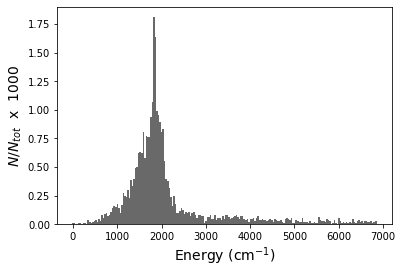

In [3]:
# compute the histogram of the energies
bins = np.linspace(np.amin(Y), np.amax(Y), 200)    
hists, edges = np.histogram(Y, bins=bins, density=True)

#plot distribution of pool
plt.bar(edges[:-1], 1000*hists, width=np.diff(edges), color='dimgray')
plt.xlabel("Energy (cm$^{-1})$", fontsize=14)
plt.ylabel("$N/N_{tot}$  x  1000", fontsize=14)
plt.show()

In [4]:
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.1, random_state=3)
# define the Random forest model 
Trees = RFR(n_estimators=100, max_features=12, max_depth=None,
            min_samples_leaf=1, min_samples_split=2, bootstrap=False, 
            n_jobs=-1)
# fit the data 
Trees.fit(X, Y)
# evaluate the test error on a test dataset 
Error_RFR = np.sqrt(mean_squared_error(Y_test, Trees.predict(X_test)))
print(f"Generalization error of the model when trained on {Y.shape[0]} training examples is: {Error_RFR}")

Generalization error of the model when trained on 51750 training examples is: 27.195416083620533


## Active learning 
The question now is whether we can achieve the same accuracy with a less amount of data using active learning algorithms. Let's start by writing an object that implements a query-by-committee strategy using the trees of a random forest regressor as the committee. We start by defining a labeler, i.e., an object that returns the energies corresponding to certain molecular geometries. In real application, the labeler is an electronic-structure solver.

In [5]:
Labeler = Y
# define the size of the initially labeled data
initial_size = 2000
Indices = np.random.choice(np.arange(np.shape(Y)[0]), size=initial_size, replace=False) # to determine initial data
Y = Y.tolist()
for i in range(np.shape(Y)[0]):
    if i not in Indices:
        Y[i] = None
Y = np.array(Y)
# create a dataset object 
dataset = Dataset(X=X, y=Y)

In [6]:
class QBCR(QueryStrategy):
    """QBC query strategy object.
    Args:
    BatchSize: int. The number of elements to query in a single AL iteration.
    Trees: an ensemble of trees sklearn instance composed of n trees.
    dataset: an object containing the labeled and unlabeled data.
    Attribs:
    make_query: choose n=BatchSize data points to query from the pool.
    """
    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)
        self.BatchSize = kwargs.pop('BatchSize', 1)
        self.Trees = kwargs.pop('Trees', None)
        if self.Trees is None:
            raise TypeError(
                "__init__() missing required keyword-only argument: 'Trees'"
            )

    def _standard_deviation(self, predictions):
        return np.std(predictions, axis=0)

    def make_query(self):
        # get the unlabeled entries, i.e. the pool data
        unlabeled_entry_ids, X_pool = self.dataset.get_unlabeled_entries()
        if len(unlabeled_entry_ids)>self.BatchSize:
            # Predict the energies of the unlabeled data
            predictions = np.array([estimator.predict(X_pool) for estimator in self.Trees.estimators_])
            # compute the standard deviation of predictions for every unlabeled datapoint
            stddev = self._standard_deviation(predictions)
            ask_idx = np.flip(np.argsort(stddev))[0:self.BatchSize]
        else:
            #The number of remaining unlabeled data is less than batch size, query the remaining data
            ask_idx = np.arange(len(unlabeled_entry_ids))

        return unlabeled_entry_ids[ask_idx]

In [7]:
BatchSize = 1000 # number of elements to query at each active learning iteration
iters = 0
errors = []

while dataset.len_unlabeled()>0: # While Pool isn't emtpy
    # get labeled entries in the pool
    X_L, y_L = dataset.get_labeled_entries()
    # train a random forest regressor on the labeled data
    Trees.fit(X_L, y_L)
    # Initialize a QBC object
    query_strategy = QBCR(Trees=Trees, BatchSize=BatchSize, dataset=dataset)
    # Compute the root mean squared error of the RFR model on the OOP data
    Error_RFR = np.sqrt(mean_squared_error(Y_test, Trees.predict(X_test)))
    errors.append(Error_RFR)
    print(f"Iteration: {str(iters)}, size of labeled data: {X_L.shape[0]}, test error: {Error_RFR} inverse centimeter")
    # for analysis purposes we'll collect some data for AL Iteration 10 
    if iters == 10: 
        y_sampled = y_L
        yp = Trees.predict(X_test)
    #Query new datapoints
    ids = query_strategy.make_query()
    # Label these datapoints and update the dataset
    dataset.update(ids, Labeler[ids])
    iters += 1


Iteration: 0, size of labeled data: 2000, test error: 394.58520212764165 inverse centimeter
Iteration: 1, size of labeled data: 3000, test error: 310.4995294371538 inverse centimeter
Iteration: 2, size of labeled data: 4000, test error: 271.0478379481371 inverse centimeter
Iteration: 3, size of labeled data: 5000, test error: 229.19607949561689 inverse centimeter
Iteration: 4, size of labeled data: 6000, test error: 203.99898777265594 inverse centimeter
Iteration: 5, size of labeled data: 7000, test error: 183.55387834992166 inverse centimeter
Iteration: 6, size of labeled data: 8000, test error: 171.4468349584541 inverse centimeter
Iteration: 7, size of labeled data: 9000, test error: 158.09904513347527 inverse centimeter
Iteration: 8, size of labeled data: 10000, test error: 144.49418840535301 inverse centimeter
Iteration: 9, size of labeled data: 11000, test error: 133.7115262938106 inverse centimeter
Iteration: 10, size of labeled data: 12000, test error: 124.1293604726151 inverse 

Now, let's plot these errors as a function of the number of training data. 





In [8]:
n_training_data = [initial_size]
for i in range(1,len(errors)): n_training_data.append(n_training_data[i-1]+BatchSize)


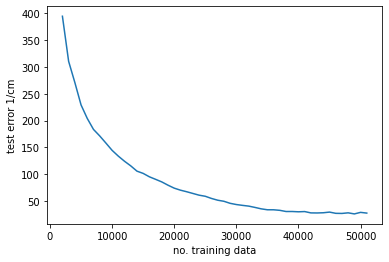

In [9]:
plt.plot(n_training_data, errors)
plt.xlabel("no. training data")
plt.ylabel("test error 1/cm")
plt.show()

Now we plot the distribution of the points collected by QBC strategy



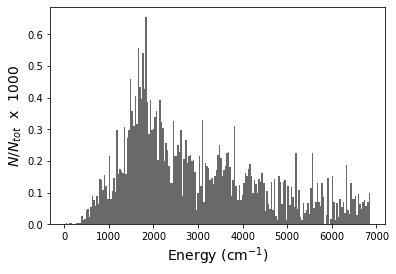

In [10]:
# compute the histogram of the energies
bins = np.linspace(np.amin(y_sampled), np.amax(y_sampled), 200)    
hists, edges = np.histogram(y_sampled, bins=bins, density=True)

#plot distribution of pool
plt.bar(edges[:-1], 1000*hists, width=np.diff(edges), color='dimgray')
plt.xlabel("Energy (cm$^{-1})$", fontsize=14)
plt.ylabel("$N/N_{tot}$  x  1000", fontsize=14)
plt.show()

Text(0, 0.5, '|E_p-E_test|')

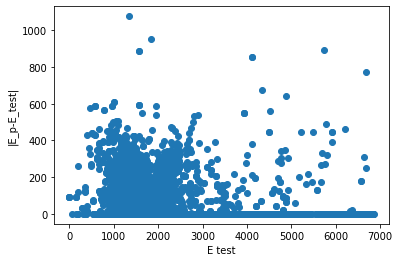

In [13]:
plt.scatter(Y_test, np.abs(yp-Y_test))
plt.xlabel("E test")
plt.ylabel("|E_p-E_test|")

## Summary and conclusion
We have seen that the query by commmittee algorithm does indeed reduce the number of electronic structure calculations needed for building a PES. However, it collects a lot of outliers, which makes it perform poorly in low-energy regions. 